In [1]:
!git clone https://github.com/Shulin-Zhang/pytorch_models.git > /dev/null 2>&1
!echo y | conda install pytorch==1.3.0 -c pytorch > /dev/null 2>&1

In [2]:
from collections import Counter
import os

import numpy as np
from matplotlib import pylab as plt
import torch
import torch.nn as nn
import torch.optim as optim
import torch.optim.lr_scheduler as lr_scheduler 
from torch.utils.data import Dataset, DataLoader

from pytorch_models.utils.lr_finder import Lr_finder

np.random.seed(100)
torch.manual_seed(100)

torch.__version__

'1.3.0'

In [3]:
raw_data_path = 'pytorch_models/couplet_generation/data/all_couplets.txt'
vocabs_size = 2000

### 划分数据集

In [4]:
def split_dataset(raw_data_path, test_size=3000):
    with open(raw_data_path, 'r') as f:
        lines = f.readlines()
        
    lines = list(map(str.strip, lines))
    
    np.random.shuffle(lines)
    
    train_lines = lines[test_size:]
    test_lines = lines[:test_size]
        
    return train_lines, test_lines

In [5]:
train_lines, test_lines = split_dataset(raw_data_path, test_size=3000)

len(train_lines), len(test_lines)

(771491, 3000)

### 获取字符表

In [6]:
def create_vocabs(train_lines, size=-1):
    counter = Counter(''.join(train_lines))
    vocabs = sorted(counter, key=lambda c: counter[c], reverse=True)
    
    if size != -1:
        vocabs = vocabs[:size]
    
    print(f"last character: {vocabs[-1]}, frequency: {counter[vocabs[-1]]}")
        
    return vocabs

In [7]:
vocabs = create_vocabs(train_lines, size=vocabs_size)

last character: 辣, frequency: 771


In [8]:
def create_index_char(vocabs):
    chars = vocabs.copy()
    chars = ['unk', ' ', 'bos'] + chars

    return dict(zip(range(0, len(chars)), chars)), dict(zip(chars, range(0, len(chars))))

In [9]:
index2char, char2index = create_index_char(vocabs)

### 创建数据集

In [10]:
class Couplets_dataset(Dataset):
    def __init__(self, lines, char2index, min_len=10, max_len=20):
        index_list = []
        
        for line in lines:
            if len(line) < min_len:
                continue
                
            stop_char_index = line.index('。')
            if stop_char_index > max_len - 1:
                continue
            
            indexs = [char2index.get(c, char2index['unk']) for c in line]
            
            padding = max_len - len(indexs)
            if padding > 0:
                indexs += [char2index[' ']] * padding
                
            index_list.append(indexs)
            
        self.data = torch.tensor(index_list)
        
    def __getitem__(self, index):
        y = self.data[index]
        x = torch.cat([torch.tensor([0]), y[:-1]])
        
        return x, y
    
    def __len__(self):
        return self.data.size(0)

In [11]:
train_set = Couplets_dataset(train_lines, char2index, max_len=30)
test_set = Couplets_dataset(test_lines, char2index, max_len=30)

In [12]:
len(train_set), len(test_set)

(646798, 2506)

In [13]:
train_loader = DataLoader(train_set, batch_size=1024, shuffle=True, num_workers=4)
test_loader = DataLoader(test_set, batch_size=1024, shuffle=False, num_workers=4)

### 创建LSTM网络

In [14]:
class Couplets_net(nn.Module):
    def __init__(self, vocabs_size, embedding_dim=100, hidden_dim=300):
        super().__init__()
        
        self.vocabs_size = vocabs_size
        self.hidden_dim = hidden_dim
        
        self.embedding = nn.Embedding(vocabs_size, embedding_dim)
        
        self.lstm_cell_0 = nn.LSTMCell(embedding_dim, hidden_dim)
        self.lstm_cell_1 = nn.LSTMCell(hidden_dim, hidden_dim)
        self.fc_1 = nn.Linear(hidden_dim, vocabs_size)
        
        self.init_weights()
        
    def init_weights(self):
        for m in self.modules():
            if isinstance(m, nn.LSTMCell):
                nn.init.xavier_normal_(m.weight_hh)
                nn.init.xavier_normal_(m.weight_ih)
            elif isinstance(m, nn.Linear):
                nn.init.kaiming_normal_(m.weight)

    def forward(self, X):   
        X = self.embedding(X)
        
        h_0 = torch.zeros(X.size(0), self.hidden_dim)
        c_0 = torch.zeros(X.size(0), self.hidden_dim)
        h_1 = torch.zeros(X.size(0), self.hidden_dim)
        c_1 = torch.zeros(X.size(0), self.hidden_dim)
        if torch.cuda.is_available():
            h_0, c_0, h_1, c_1 = h_0.to('cuda'), c_0.to('cuda'), h_1.to('cuda'), c_1.to('cuda')
        
        Y_out = []
        
        for i in range(X.size(1)):
            X_step = X[:, i]
                        
            h_0, c_0 = self.lstm_cell_0(X_step, (h_0, c_0))
            h_1, c_1 = self.lstm_cell_1(h_0, (h_1, c_1))
            X_step = self.fc_1(h_1)
            
            Y_out.append(X_step)
            
        return torch.stack(Y_out).transpose(0, 1)
    
    def sample(self, stop_index):
        X_step = torch.zeros(1, dtype=torch.long)
        
        h_0 = torch.zeros(1, self.hidden_dim)
        c_0 = torch.zeros(1, self.hidden_dim)
        h_1 = torch.zeros(1, self.hidden_dim)
        c_1 = torch.zeros(1, self.hidden_dim)
        if torch.cuda.is_available():
            X_step = X_step.to('cuda')
            h_0, c_0, h_1, c_1 = h_0.to('cuda'), c_0.to('cuda'), h_1.to('cuda'), c_1.to('cuda')
        
        Y_out = []
        
        while True:
            X_step = self.embedding(X_step.view(-1, 1))[:, 0]
            
            h_0, c_0 = self.lstm_cell_0(X_step, (h_0, c_0))
            h_1, c_1 = self.lstm_cell_1(h_0, (h_1, c_1))
            X_step = self.fc_1(h_1)
            X_step = nn.functional.softmax(X_step, dim=-1)
            
            X_step[:, char2index['unk']] = 0
            out_index = torch.multinomial(X_step, 1).squeeze().cpu().item()
            Y_out.append(out_index)
            
            X_step = torch.zeros(1, 1, dtype=torch.long)
            X_step[:, 0] = out_index
            
            if torch.cuda.is_available():
                X_step = X_step.to('cuda')
            
            if out_index == stop_index:
                break
            
        return np.array(Y_out)

In [15]:
model = Couplets_net(len(char2index))

### 搜索最大学习率

In [16]:
def create_loss():
    loss_fn = nn.CrossEntropyLoss()

    def new_loss_fn(outputs, labels):
        outputs = outputs.reshape((-1, outputs.size(-1)))
        labels = labels.reshape((-1))
        loss = loss_fn(outputs, labels)
        return loss
    
    return new_loss_fn

In [17]:
lr_finder = Lr_finder(model, train_loader, create_loss(), optim.SGD(model.parameters(), 0.1, weight_decay=0))

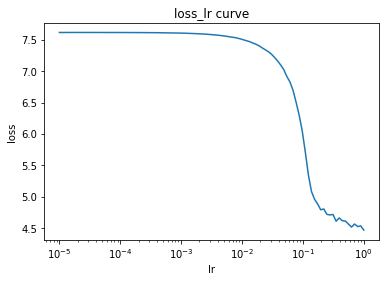

In [18]:
lr_finder.lr_find(steps=100, lr_range=(1e-5, 1), plot=True, repeat=2)

### 训练

In [19]:
class Learner:
    def __init__(self, model):
        if torch.cuda.is_available():
            self.model = model.to('cuda')
        else:
            self.model = model

    def fit(self, dataloader, lr, epochs, weight_decay=0, print_steps=200):
        self.model.train()

        loss_fn = nn.CrossEntropyLoss()
        optimizer = optim.SGD(self.model.parameters(), lr, momentum=0.9,
                              weight_decay=weight_decay, nesterov=False)
        scheduler = lr_scheduler.OneCycleLR(optimizer, lr, epochs=epochs,
                                            steps_per_epoch=len(dataloader))

        history_loss = []
        history_steps = []
        for epoch in range(epochs):
            for step, (X, Y) in enumerate(dataloader):
                if torch.cuda.is_available():
                    X, Y = X.to('cuda'), Y.to('cuda')

                outputs = self.model(X)
                outputs = outputs.reshape((-1, outputs.size(-1)))
                Y = Y.reshape((-1))
                loss = loss_fn(outputs, Y)
                optimizer.zero_grad()
                loss.backward()
                optimizer.step()
                scheduler.step()

                if step % print_steps == print_steps - 1:
                    history_loss.append(loss.item())
                    history_steps.append(epoch * len(dataloader) + step + 1)
                    print(f"epoch: {epoch + 1}    \tstep: {step + 1}    \tloss: {loss:.4f}")

        return history_steps, history_loss

    def evaluate(self, dataloader):
        self.model.eval()
        
        loss_fn = nn.CrossEntropyLoss()

        losses = []

        with torch.no_grad():
            for X, Y in dataloader:
                if torch.cuda.is_available():
                    X, Y = X.to('cuda'), Y.to('cuda')

                outputs = self.model(X)
                outputs = outputs.reshape((-1, outputs.size(-1)))
                Y = Y.reshape((-1))
                loss = loss_fn(outputs, Y)
                losses.append(loss.item())

        return np.average(losses)

    
    def sample(self, times=8):
        self.model.eval()
        
        with torch.no_grad():
            for _ in range(times):
                samples = self.model.sample(char2index['。'])
                chars = [index2char[index] for index in samples]
                sentence = ''.join(chars)
            
                print(sentence)

In [20]:
learn = Learner(model)

In [21]:
history_steps, history_loss = learn.fit(train_loader, 0.3, 40, weight_decay=0, print_steps=500)

epoch: 1    	step: 500    	loss: 3.8391
epoch: 2    	step: 500    	loss: 3.5560
epoch: 3    	step: 500    	loss: 3.5512
epoch: 4    	step: 500    	loss: 3.5264
epoch: 5    	step: 500    	loss: 3.4439
epoch: 6    	step: 500    	loss: 3.3570
epoch: 7    	step: 500    	loss: 3.1455
epoch: 8    	step: 500    	loss: 3.1033
epoch: 9    	step: 500    	loss: 3.0046
epoch: 10    	step: 500    	loss: 2.9352
epoch: 11    	step: 500    	loss: 2.8916
epoch: 12    	step: 500    	loss: 2.8696
epoch: 13    	step: 500    	loss: 2.8192
epoch: 14    	step: 500    	loss: 2.7439
epoch: 15    	step: 500    	loss: 2.7922
epoch: 16    	step: 500    	loss: 2.7200
epoch: 17    	step: 500    	loss: 2.6986
epoch: 18    	step: 500    	loss: 2.6885
epoch: 19    	step: 500    	loss: 2.6512
epoch: 20    	step: 500    	loss: 2.6397
epoch: 21    	step: 500    	loss: 2.6344
epoch: 22    	step: 500    	loss: 2.6654
epoch: 23    	step: 500    	loss: 2.6292
epoch: 24    	step: 500    	loss: 2.6074
epoch: 25    	step: 500  

Text(0, 0.5, 'loss')

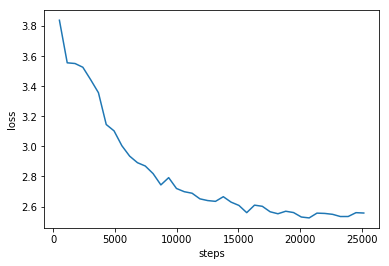

In [22]:
plt.plot(history_steps, history_loss)
plt.xlabel('steps')
plt.ylabel('loss')

In [23]:
learn.evaluate(test_loader)

2.531624952952067

In [25]:
learn.sample(times=30)

夜月樽前，看谁是小字听蝉韵；南山乱下，石上托题松觅月中。
高袖冲衣，泉边胜迹；灵台芳阁，座右方边。
并岭上凤丁，有我有爱忙税洞；菩提中赤手，大刀成梦紧飞天。
足薄悲常心，天庄台开双去岁；天天和雪盛，笑人裕来万阙先。
旧句还书红叶上；此主之别题风流。
盛世若凭同创业；贵田先启太高宗。
水漫渔船休把酒；帆扬曲径续知音。
且开每景清茶雾；谁能真人向参天。
风飞暮鼓楼台软；雪语风中大肚红。
残尽履填红，十酿桃花常悦目；支拔连营己，四知仙腹自来贫。
和平民乐欢，乐山河水自知乐；屏贴心添德，异地家家画本常。
嫦娥啸到星光，昔励方终越；老汉乃稀热以，难回望等明。
过峰脚立丹枫美；沐雨温连锦绣新。
八方对月天真地；一壁离人知老师。
江门两吊渔，高瞻斜照；芦溪船多意，序派炎黄。
接害衰林，端戒难为家国事；前程汉信，仁心甘逸百年春。
有善多奉公，为谁已易；潮虽无双手，不可当思。
神州出络韵；岸绿彩长钟。
早读无言付曲水；胆存须恋问君王。
直角天然云态换；观朝大雨浪丘来。
山无红叶飘来翠；夜觉春光共放红。
相思网上看何处；有人情语系五觞。
琴音释腹即然日；泥水屏刀生破吴。
绿米芳菲，兴留冰容凝玉露；铜粉化苗，不怜惹谷楚天秋。
潇湘句默如山姓；月影烟光有肚头。
白泼梅身坡伞笋；风摇水水柳青弦。
炮空正气催旗起；旧调沙声免对长。
佛降荒山，莫无双尺丘仙座；崖清晓恨，醉有东江汉起琴。
教子读书诚读记；冠家文采世良邻。
出大文章凡世事；犹思故里为公心。
